![](pics/header2.png)

# Quadcopter Dynamics and Control

by Kevin J. Walchko, Phd

July 2021

---

# References

- [Quadcopter: System Modelling](https://www.wilselby.com/research/arducopter/modeling/)
- [Quadcopter: Control System Design](https://www.wilselby.com/research/arducopter/controller-design/)
- [Modeling Vehicle Dynamics – Quadcopter Equations of Motion](https://charlestytler.com/quadcopter-equations-motion/)
- Matlab: [6DOF (Euler Angles)](https://www.mathworks.com/help/aeroblks/6dofeulerangles.html)
- [EMAX MT2204 2300KV Motor](https://oscarliang.com/emax-mt2204-mt1806-motor-quadcopter-1804/)
- [Spacecraft and Aircraft Dynamics](http://control.asu.edu/Classes/MMAE441/Aircraft/441Lecture9.pdf)
- [Working Principle and Components of Drone](https://cfdflowengineering.com/working-principle-and-components-of-drone/)
- [Drone Building Guide](https://ramyadhadidi.github.io/files/Drone-Build-Guide.pdf)

## Simulink Reference

Using the 6DoF block as an idea for how to build my drone model.

![](pics/simulink-block.gif)

![](pics/simulink-frame.png)

The dynamics follow a typical Aerospace body reference frame where x-axis is out the nose, y-axis is along the right wing, and z-axis is down. Then the inertial reference frame is aranged similarly and located at some place on the Earth. Here we will use a NED frame (North, East, Down) for this inertial frame. Again, common in US Aerospace.

## Variables and Units

| Variable         | Units   | Definition |
|------------------|:-------:|:-----------|
| $F_i$      | N       | Force      |
| $\tau_i$   | Nm      | Moment     |
| $\gamma$   | m       | torque/force ratio |
| $n$        | rpm     | motor shaft speed |
| $\omega$   | rad/sec | rotation rate of the drone body $\begin{bmatrix} p & q & r \end{bmatrix}^T$ |
| $L$        | m       | distance from CoM to motor |
| $J$        | $kg.m^2$| rotational inertia |
| $I_m$      | $kg.m^2$| motor inertia |
| $v_{NED}$  | m/sec   | linear velocity |
| $p_{NED}$  | m       | position |
| KV         | RPM/V   | motor rating, typically you need to use $\pi$/60 to convert to rad/sec |
| $k_f$      | N/$rad^2$ | motor force constant |
| $k_t$      | Nm/$rad^2$ | motor torque constant |


| Symbol | Description                                                          |
|:-------|:---------------------------------------------------------------------|
| $v_{frame}$ | Vector measured in a reference frame                                 |
| $R_{to}^{from}$ | Rotation matrix which transforms from one reference frame to another |


## Motion

The diagram below shows the direction of the propellers spining. By increasing the speed and decreasing the speed of the combinations of motors, the following can be achieved: up, down, roll, pitch, and rotate about z-axis. Note, that the system is under actuated, since there is no direct way to move in the horizontal plane without some combination of roll/pitch first. Thus there is 1 DoF for z-axis translational motion and 3 DoF for rotational motion for a total of 4 DoF.

<img src="pics/movement.jpg" width="50%"> </td>

Remeber, the diagrams above show propellor spin direction. Since the propellor is pushing on the air as it spins, this causes the resulting torque transfered to the aircraft frame to be in the opposite direction.

### Forces and Torques

$$
F_i = k_F n_i^2 \\
\tau_i = k_M n_i^2 + I_m \dot n_i
$$

So we can simplify the motor torque by with the assumption, the motor speeds are generally constant and only change speeds over a very short time:

$$
\dot n_i \approx 0 \\ 
\tau_i = k_M n_i^2 + I_m \dot n_i \to \tau_i = k_M n_i^2
$$

Also, for deriving equations, since there is a relationship between forces and
torques, we can write:

$$
\frac {\tau_i}{F_i} = \frac {k_M n_i^2}{k_F n_i^2} = \frac {k_M}{k_F} = \gamma \to \tau_i = \gamma F_i
$$

Note that although the motor constants $k_M$ and $k_F$ are shown as constant, they do vary with air density, temperature, friction, etc.


### Motors

Motors usually have a KV value associated with them which relates RPM to voltage. Ideally, this number should tell you how many RPMs you will get if you provde a voltage to the motor. 

$$
\tau = k_t I \\
k_t = \frac {1}{KV} \\
\tau  = \frac {60}{2 \pi} \frac{1}{KV} I
$$

Since motor torque is proportional to current ($I$), we can substitute in the motor's KV (and convert from RPM/V to rad/sec/V) and calculate the torque. This equation is typically off by 10% - 50%, so it is not perfect.

## Propeller

<img src="pics/propeller-forces.jpg" width="35%" >

The force produced by a propeller blade is lift ($l_i$) and is located at the center of pressure ($C_i$) of each blade. The total thrust ($t$) is the sum of the lift of each blade. The torque produced by the aerodynamic drag which acts in the opposite direction as the motor angular velocity ($n$).

## Dynamics

![](pics/quadcopter.png )

$$
\begin{align*}
\Phi &= \begin{bmatrix} \vec{p}_{NED} && \vec{v}_{NED} && \omega && q \end{bmatrix}_I^T \\
\dot \Phi &= f_b(\Phi, u)
\end{align*}
$$

where $f_b()$ is the nonlinear function for the EoM for the quadcopter and NED is North, East, Down reference frame that will be our inertial (I) frame.

$$
\vec{F}_{NED} = R_I^b \vec{F}_b
$$

Since our control forces (thrust force) is fixed in body frame, we will need to rotate it into the inertial NED frame.

### Translational

Starting with Newton's Law:

$$
m \frac{dv_{NED}}{dt} = m \dot v_{NED} = F_NED \\
$$

$$
m \dot v_{NED} =  (F_T)_{NED} - m \vec{g} \\
\dot v_{NED} = R^b_I F_T / m - \vec{g}
$$

where $F_T$ is the thrust vector given by:

$$
F_{Tb} = \begin{bmatrix} 0 && 0 && -F_1 - F_2 - F_3 - F_4 \end{bmatrix}^T \\
F_{TNED} = R_{NED}^{b} F_{Tb}
$$

The gravity term is given by:

$$
\vec{g} = \begin{bmatrix} 
    0 && 0 && 9.80665
\end{bmatrix}^T 
$$


### Rotational

Let's start with assuming the drone is symetrical, then the inertia ($J$) is:

$$
J = 
\begin{bmatrix}
  J_x & 0 & 0 \\
  0 & J_y & 0 \\
  0 & 0 & J_z
\end{bmatrix}
$$

Additionally, if we assume the drone is in an X shape, then $J_x = J_y$. However, just in case it isn't because of payload, we won't simplify the equations below. 

Euler's Equation in the *body frame*: 

$$
J \dot \omega + \omega \times (J \omega) = \tau \\
J \dot \omega = \tau - \omega \times (J \omega) \\
\dot \omega = J^{-1}[\tau - \omega \times (J \omega)] \\
\dot \omega = 
  \begin{bmatrix}
    \tau_x/J_x \\
    \tau_y/J_y \\
    \tau_z/J_z \\
  \end{bmatrix} - 
  \begin{bmatrix}
    \frac {J_y - J_z}{J_x} q \cdot r \\
    \frac {J_z - J_x}{J_y} p \cdot r \\
    \frac {J_x - J_y}{J_z} p \cdot q \\
  \end{bmatrix}
$$

where $\omega^b = \begin{bmatrix} p & q & r \end{bmatrix}^T$. Now you can define your control input as a combination of motor forces, motor locations, and force/torque ratios. Use  $\tau_i = \gamma F_i$ in the derivation. Looking at the motor forces in the free body diagram, the table below shows the motor forces interaction with rotational torques.


| Torque   | F1 | F2 | F3 | F4 |
|----------|----|----|----|----|
| $\tau_x$ | -  | +  | +  | -  |
| $\tau_y$ | +  | -  | -  | +  |
| $\tau_z$ | +  | +  | -  | -  |

$$
\tau =
\begin{bmatrix} 
  -L &  L &  L & -L \\
   L & -L &  L & -L \\
   \gamma &  \gamma & -\gamma & -\gamma
\end{bmatrix}
\begin{bmatrix} F_1 \\ F_2 \\ F_3 \\ F_4 \end{bmatrix} \\
F_i = k_f \cdot n_i^2
$$

where $L$ is the distance between a motor and an axis. The assumption is the quadcopter is in an X layout and each motor is the same distance from the x-axis or y-axis and therefore produces the same torque. Torque about the z-axis is due to the aerodynamic drag force and acts in the opposite direction of the rotor spin.

## Dynamics Summary

So combining everything above, the result is:

$$
\begin{bmatrix}
    \dot p_{NED} \\
    \dot v_{NED} \\
    \dot \omega \\
    \dot q
\end{bmatrix} =
\begin{bmatrix}
    v_{NED} \\
    R^b_I \frac {F_T} {m} - \vec{g} \\
    J^{-1}[\tau - \omega \times (J \omega)] \\
    \frac {1}{2} q \otimes \omega
\end{bmatrix}
$$

$$
\tau =
\begin{bmatrix} 
  -L &  L &  L & -L \\
   L & -L &  L & -L \\
   \gamma &  \gamma & -\gamma & -\gamma
\end{bmatrix}
\begin{bmatrix} F_1 \\ F_2 \\ F_3 \\ F_4 \end{bmatrix} \\
F_i = k_f \cdot n_i^2
$$

$$
F_{T} = \begin{bmatrix} 0 && 0 && -F_1 - F_2 - F_3 - F_4 \end{bmatrix}^T \\
$$

$$
\vec{g} = \begin{bmatrix} 
    0 && 0 && 9.80665
\end{bmatrix}^T 
$$

## Control Law

Using the dynamics of the quadcopter and its motor forces, the table below gives the torque directions for commands.

| Command | F1 | F2 | F3 | F4 |
|---------|----|----|----|----|
| Roll    | -  | +  | +  | -  |
| Pitch   | +  | -  | +  | -  |
| Yaw     | +  | +  | -  | -  |

Using the above table, we can define a matrix that converts errors into motor speeds.

$$
\begin{align*} 
u &= u_{trim} + u_{\Delta attitudeError} + u_{\Delta positionError} \\
\begin{bmatrix} n_1 && n_2 && n_3 && n_4 \end{bmatrix}^T  &= M \cdot cmds \\
  &= 
\begin{bmatrix}
    1 && -1 &&  1 &&  1 && 1 \\
    1 &&  1 && -1 &&  1 && 1 \\
    1 &&  1 &&  1 && -1 && 1 \\
    1 && -1 && -1 && -1 && 1 \\
\end{bmatrix}
\begin{bmatrix} 
    \sqrt{\frac{mg}{4 k_f}} \\
    - kp \cdot \phi - kd \cdot \omega_x \\
    - kp \cdot \theta - kd \cdot \omega_z \\
    - kp \cdot \psi - kd \cdot \omega_y \\
    kp \cdot z + kd \cdot \dot z
\end{bmatrix}
\end{align*}
$$

where $u_{trim}$ is the motor force needed to negate the mass of the quadcopter and hold it at a constant altitude. Basically, each motor (4) needs to account for a quarter of the quadcopter's weight.

$$
mg/4 - F_T = 0 \\
F_T = mg/4 \\
k_f n^2 = mg/4 \\
n = \sqrt{\frac{mg}{4 k_f}}
$$

The $attitudeError$ and $positionError$ are based on commands for position or orientation of the quadcopter.

In [6]:
# reload library
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
from numpy import cos, sin
from matplotlib import pyplot as plt
from collections import deque

In [8]:
from scipy.integrate import solve_ivp as rk45
from squaternion import Quaternion
from tqdm import tqdm

In [9]:
from thundercougarfalconbird import ParrotDrone
from jtb import getCodeImport

In [10]:
# let's take a look at the dynamics
getCodeImport(ParrotDrone.eqns)

In [11]:
rpm2w = 2*np.pi/60
w2rpm = 60/2/np.pi

rad2deg = 180/np.pi
deg2rad = np.pi/180

def R321(a,b,c, degrees=False):
    """Returns a rotation matrix based on: X*Y*Z"""
    if degrees:
        a *= deg2rad
        b *= deg2rad
        c *= deg2rad

    s3 = np.sin(c); c3 = np.cos(c)
    s2 = np.sin(b); c2 = np.cos(b)
    s1 = np.sin(a); c1 = np.cos(a)

    return np.array(
        [
            [         c1*c2,          c2*s1,  -s2],
            [c1*s2*s3-c3*s1, c1*c3+s1*s2*s3, c2*s3],
            [s1*s3+c1*c3*s2, c3*s1*s2-c1*s3, c2*c3]
        ]
    )

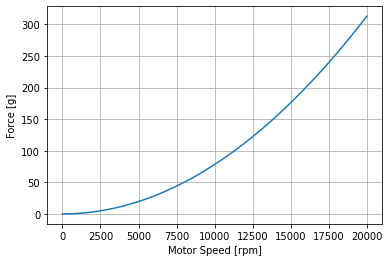

In [5]:
rpm = np.arange(0,20000)
F = 1000*params['kf'] * (rpm2w*rpm)**2 / 9.81
plt.plot(rpm, F)
plt.ylabel("Force [g]")
plt.xlabel("Motor Speed [rpm]")
plt.grid(True);

In [6]:
print(f"Quadcopter mass {params['m']} kg, weight {params['m']*9.81:.2f} N")

ff = 4*params['kf']*1073**2
gg = 1000/9.81*ff
print(f"Total needed thrust force: {ff:.3f} N or {gg:.0f} g")

nn = np.sqrt(params['m']*9.81/params['kf']/4)
print(f"Trim motor settings: {nn*w2rpm:.0f} rpm, {nn:.1f} rad/s")

Quadcopter mass 0.329 kg, weight 3.23 N
Total needed thrust force: 3.224 N or 329 g
Trim motor settings: 10252 rpm, 1073.6 rad/s


In [103]:
# I am going to create a new class with a controller ... don't have to 
# do it this way, but I can
class myParrotDrone(ParrotDrone):
        
    def pd(self, state, zd):
        # x = [p,v,w,q] => 13
        kp = 300 # 300
        kd = 40  # 40
        
        qq = Quaternion(*state[-4:])
        att = np.array(qq.to_euler())
        w = np.array(state[6:9])
        ur = (kp*att + kd*w)
        
        mr = np.array([
            [1,-1, 1, 1, 1],
            [1, 1,-1, 1, 1],
            [1, 1, 1,-1, 1],
            [1,-1,-1,-1, 1]
        ])
        
        # trim = 1070 # rad/s
        trim = np.sqrt(self.m*9.81/self.kf/4)
        uh = 0
        pos = state[:3] - np.array([0,0,zd])
        vel = state[3:6]
        # uh = (300 * (pos[2]) + 300*vel[2])
        up = (300 * (pos) + 300*vel)
        
        # uu = np.zeros(5)
        # uu[0] = trim
        # uu[1:4] = -ur
        # uu[4] = uh
        
        # uu = m @ [trim, -ur(3), uh]
        
        # u = m[:,1:] @ uh
        
        mp = np.array([
            [0,0,1],
            [0,0,1],
            [0,0,1],
            [0,0,1]
        ])
        
#         a = 0.05
#         b = a
        
#         mp = np.array([
#             [-a, b,1],
#             [ a,-b,1],
#             [ a, b,1],
#             [-a,-b,1]
#         ])

        # trim: minimum speed to hold altitude
        # mr/ur: rotation motor matrix and control
        # mp/up: position motor matrix and control
        u = np.ones(4)*trim +  mr[:,1:4] @ -ur  + mp @ up
        
        # saturate control command
        sat = 20000*rpm2w
        for i, x in enumerate(u):
            if x < 0:
                u[i] = -x
            if x > sat:
                u[i] = sat
        
        return u
            

In [104]:
step = 0.01
steps = 1000

drone = myParrotDrone()

zd = 6

y = np.zeros(13)

y[:3] = 0,0,1
y[6:9] = 0.,0.,0. # wx, wy, wz [rads/sec]
y[9:] = Quaternion.from_euler(10,-10,10, degrees=True)
t = 0.0

ui = []
yi = []
ti = []

for _ in tqdm(range(steps)):
    # x = [p,v,w,q] => 13
    u = drone.pd(y, zd)
    # u = np.ones(4)*1070
    ui.append(u)
    
    y = rk45(drone.eqns, [t, t+step], y, args=(u,))
    # print(y)
    if y.success == False:
        print("Oops")
        
    y = y.y[:,-1]
    drone.q = Quaternion(*y[9:])
    ti.append(t)
    yi.append(y)
    # ui.append(u)
    t += step
    
# print(f"{len(ui)}")

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1070.87it/s]


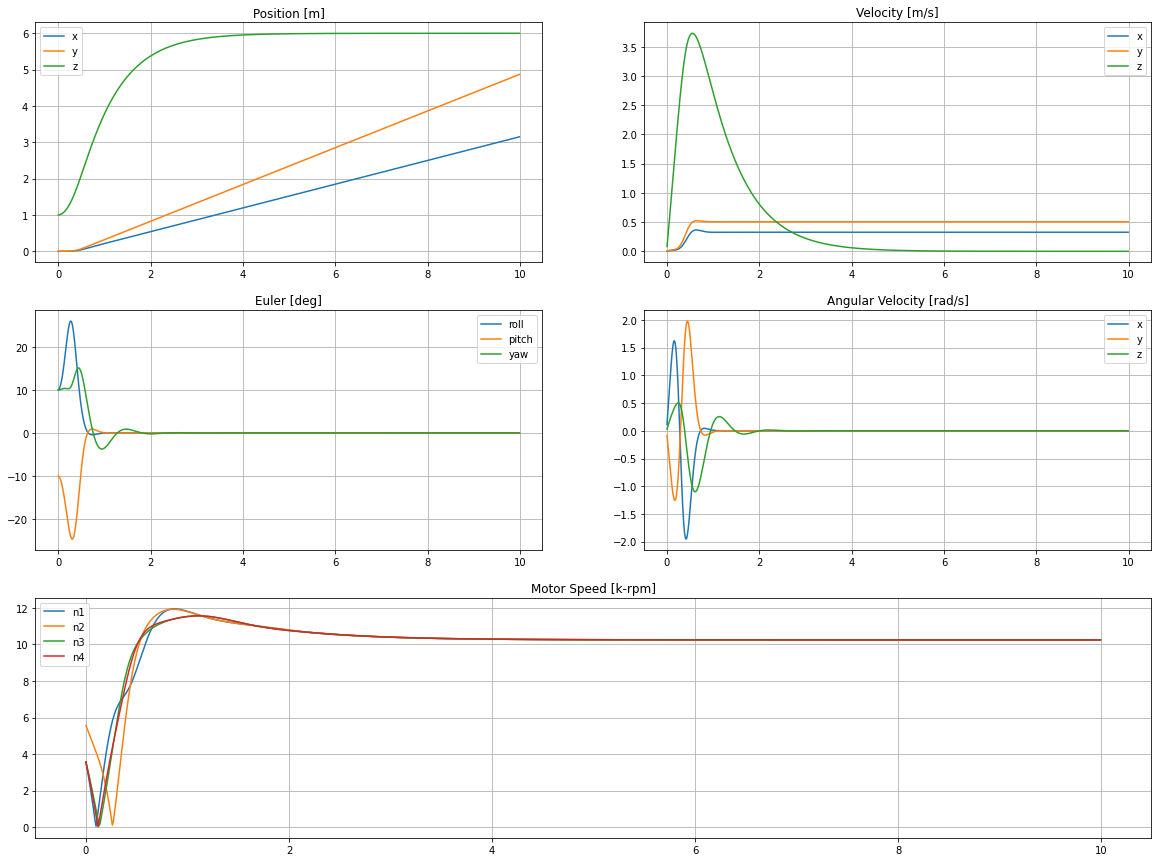

In [105]:
p = []
v = []
w = []
euler = []
for y in yi:
    q = Quaternion(*y[9:])
    euler.append(q.to_euler(True))
    # R = q.to_rot()
    # p.append(R @ y[:3])   # position [m]
    # v.append(R @ y[3:6])  # velocity [m/s]
    p.append(y[:3])   # position [m]
    v.append(y[3:6])  # velocity [m/s]
    w.append(y[6:9])  # w [rads/s]
v = np.array(v)
w = np.array(w)
p = np.array(p)
u = np.array(ui)/1000*w2rpm # rad/s -> rpm
euler = np.array(euler)

plt.subplots(figsize=(20,15))

plt.subplot(3,2,1)
plt.plot(ti, p[:,0], label="x")
plt.plot(ti, p[:,1], label="y")
plt.plot(ti, p[:,2], label="z")
plt.legend()
plt.title('Position [m]')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(ti, v[:,0], label="x")
plt.plot(ti, v[:,1], label="y")
plt.plot(ti, v[:,2], label="z")
plt.legend()
plt.title('Velocity [m/s]')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(ti, euler[:,0], label="roll")
plt.plot(ti, euler[:,1], label="pitch")
plt.plot(ti, euler[:,2], label="yaw")
plt.legend()
plt.title('Euler [deg]')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(ti, w[:,0], label="x")
plt.plot(ti, w[:,1], label="y")
plt.plot(ti, w[:,2], label="z")
plt.legend()
plt.title('Angular Velocity [rad/s]')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(ti, u[:,0], label="n1")
plt.plot(ti, u[:,1], label="n2")
plt.plot(ti, u[:,2], label="n3")
plt.plot(ti, u[:,3], label="n4")
plt.legend()
plt.title('Motor Speed [k-rpm]')
plt.grid(True)

# plt.subplot(1,3,3)
# plt.plot(ui);

In [59]:
np.matmul(np.eye(4,3),(np.array([2,2,2])))

array([2., 2., 2., 0.])

In [23]:
np.ones(4) * 5

array([5., 5., 5., 5.])

# Appendix A: Body Dynamics

Old way ... put everything into body frame. Not doing this since I care about position in global frame.

Starting with Newton's Law:

$$
m \frac{dv}{dt} = m \dot v = F_I \\
$$

$$
m \frac{dv}{dt} \bigg|_I = m \left( \dot v_b + \omega \times v_b \right) = F_b
$$

$$
m \left( \dot v_b + \omega \times v_b \right) =  F_T - m \vec{g_b} \\
\dot v_b = F_T / m - \vec{g}_b - \omega \times v_b
$$

where $F_T$ is the thrust vector given by:

$$
F_T = \begin{bmatrix} 0 && 0 && -F_1 - F_2 - F_3 - F_4 \end{bmatrix}^T
$$

The gravity term is given by:

$$
\vec{g}_b = R_{n}^{b} \vec{g}_n = \begin{bmatrix} 
    c_{\theta}c_{\psi} & c_{\theta}s_{\psi} & -s_{\theta} \\ 
    -c_{\theta}s_{\psi}+s_{\phi}s_{\theta}c_{\psi} & c_{\phi}c_{\psi}+s_{\phi}s_{\theta}s_{\psi} & s_{\phi}c_{\theta} \\
    s_{\phi}s_{\psi}+c_{\phi}s_{\theta}c_{\psi} & -s_{\phi}c_{\psi}+c_{\phi}s_{\theta}s_{\psi} & c_{\phi}c_{\theta} \end{bmatrix} 
\begin{bmatrix} 0 \\0\\g \end{bmatrix} \\
\vec{g}_b = \begin{bmatrix} 
    -mg\sin(\theta) \\
    g\sin(\phi)\cos(\theta) \\
    mg\cos(\phi)\cos(\theta) 
\end{bmatrix} 
$$

# Appendix B: Rigid Body Attitude

## Euler Angles

To update the orientation of the quadcopter, you *could* use the following relationship.

$$
\begin{bmatrix} \dot \phi \\ \dot \theta \\ \dot \psi \end{bmatrix} = 
\begin{bmatrix} 
    1 && \sin \phi \tan \theta && \cos \phi \tan \theta \\
    0 && \cos \phi && -\sin \phi \\
    0 && \sin \phi \sec \theta && \cos \phi \sec \theta
\end{bmatrix}
\begin{bmatrix} p \\ q \\ r \end{bmatrix}
$$

where $\theta \ne \pi/2$ and if both $\phi$ and $\theta$ are close to 0 (when quadcopter is hovering), then the matrix becomes the identify matrix. 

**WARNING:** Euler angles are horrible to work with since they have dicontinuities, instead we will use quaternions.

## Quaternions

Integrating Euler angles using the above can lead to issues, so typically you choose to use quaternions instead. Here I will use the Hamilton definition and not the JPL definition for a quaternion.

$$
q = [ w, x, y, z ] \\
x_{inertial} = q \otimes x_{body} \otimes q^* \\
\dot q = \frac {1}{2} q \otimes \omega
$$

where $w$ is the real part and the $(x,y,z)$ is the imaginary part of the quaternion.